## MEGNet: Graph Networks as a Universal Machine Learning Framework for Molecules and Crystals

ABSTRACT:
Graph networks are a new machine learning (ML) paradigm that supports both
relational reasoning and combinatorial generalization. Here, we develop, for the first
time, universal MatErials Graph Network (MEGNet) models for accurate property
prediction in both molecules and crystals. We demonstrate that our MEGNet models significantly outperform prior ML models in 11 out of 13 properties of the QM9
molecule data set. Furthermore, a single-task unified MEGNet model can accurately
predict the internal energy at 0 K and room temperature, enthalpy and Gibbs free
energy, with temperature, pressure and entropy being global state inputs. Similarly,
we show that MEGNet models trained on ∼ 60, 000 crystals in the Materials Project
substantially outperform prior ML models in the prediction of the formation energies,
band gaps and elastic moduli of crystals, achieving better than DFT accuracy over
a much larger data set. Such MEGNet models are highly interpretable, and wellestablished periodic chemical trends can be extracted from the elemental embeddings.
Finally, we demonstrate the transfer learning of elemental embeddings from a property
model trained on a larger data set (formation energies) to accelerate the training of
property models with smaller amounts of data (band gaps and elastic moduli).

Link to paper: https://arxiv.org/pdf/1812.05055v1.pdf

Credit: https://github.com/materialsvirtuallab/megnet

Google Colab: https://colab.research.google.com/drive/1dvePXBmBCvQ-7a4CL0plLzr_5IyO0rbK?usp=sharing

In [ ]:
# For the latest dev version, we'll clone this repo
!git clone https://github.com/materialsvirtuallab/megnet.git
%cd megnet

# and install megnet via the command
!python setup.py develop

# Install monty and pymatgen
!pip install "monty==3.0.2" pymatgen==v2021.3.3

### Tutorial: Crystal Example

#### Load data

In [2]:
import numpy as np 

from monty.json import MontyDecoder
from monty.serialization import loadfn

data = loadfn('megnet/notebooks/bulk_moduli.json')
structures = data['structures']
targets = np.log10(data['bulk_moduli'])

#### Set up model and train

In [3]:
from megnet.data.crystal import CrystalGraph
from megnet.data.graph import GaussianDistance
from megnet.models import MEGNetModel

model = MEGNetModel(10, 2, nblocks=1, lr=1e-2,
                    n1=4, n2=4, n3=4, npass=1, ntarget=1,
                    graph_converter=CrystalGraph(bond_converter=GaussianDistance(np.linspace(0, 5, 10), 0.5)))

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [4]:
model.train(structures, targets, epochs=2)

Epoch 1/2
1/1 [==============================] - 6s 6s/step - loss: 3.9653
Epoch 2/2
1/1 [==============================] - 0s 160ms/step - loss: 3.5815


#### Prediction

##### Predict from structure

In [6]:
from pymatgen import MPRester
mpr = MPRester("vWC9tcxNPVb1sJBn")

# let's get some structure
structure = mpr.get_structure_by_material_id('mp-1143')

In [7]:
predicted_K = 10 ** model.predict_structure(structure).ravel()
print('The predicted K for {} is {} GPa'.format(structure.formula, predicted_K[0]))

The predicted K for Al4 O6 is 1.5983375310897827 GPa


### Tutorial: Model Reconstruct

#### Reconstruct new models without embedding

In [8]:
from megnet.models import MEGNetModel
from megnet.data.graph import GaussianDistance
from megnet.data.crystal import CrystalGraph
import numpy as np

# Pretrained model
model_pretrained = MEGNetModel.from_file('megnet/mvl_models/mp-2018.6.1/band_gap_regression.hdf5')

# New model with length 16 atom feature
cg = CrystalGraph(bond_converter=GaussianDistance(np.linspace(0, 5, 100), 0.5), cutoff=4)
model_new = MEGNetModel(100, 2, 16, graph_converter=cg)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [9]:
# Get pretrained weights
weights = model_pretrained.get_weights()

# The first weight is the element embedding
emb = weights[0] 

# The new model has exact the same layers except the embedding layer
model_new.set_weights(weights[1:])

In [11]:
from pymatgen import MPRester

mpr = MPRester("vWC9tcxNPVb1sJBn")
s = mpr.get_structure_by_material_id('mp-129')

In [12]:
# Pretrained model prediction
model_pretrained.predict_structure(s)

array([0.03076014], dtype=float32)

In [13]:
# Concert manually the atomic number into an atomic feature
graph = model_new.graph_converter.convert(s)
graph['atom'] = [emb[i] for i in graph['atom']]

In [14]:
# Same prediction results
model_new.predict_graph(graph)

array([0.03076014], dtype=float32)

### Tutorial: QM9 Pretrained

#### Load QM9 model and predict

In [28]:
from megnet.models import MEGNetModel
import numpy as np

from operator import itemgetter
import json

def get_graph_from_doc(doc):
    """
    Convert a json document into a megnet graph
    """
    atom = [i['atomic_num'] for i in doc['atoms']]

    index1_temp = [i['a_idx'] for i in doc['atom_pairs']]
    index2_temp = [i['b_idx'] for i in doc['atom_pairs']]
    bond_temp = [i['spatial_distance'] for i in doc['atom_pairs']]

    index1 = index1_temp + index2_temp
    index2 = index2_temp + index1_temp
    bond = bond_temp + bond_temp
    sort_key = np.argsort(index1)
    it = itemgetter(*sort_key)

    index1 = it(index1)
    index2 = it(index2)
    bond = it(bond)
    graph = {'atom': atom, 'bond': bond, 'index1': index1, 'index2': index2, 'state': [[0, 0]]}
    return graph
    
# load an example qm9 document
with open('megnet/megnet/data/tests/qm9/000001.json', 'r') as f:
    doc = json.load(f)

# convert to a graph
graph = get_graph_from_doc(doc)

In [31]:
# all target names
names = ['mu', 'alpha', 'HOMO', 'LUMO', 'gap', 'R2', 'ZPVE', 'U0', 'U', 'H', 'G', 'Cv', 'omega1']

y_pred = []
y_true = []

print('*** Result Comparisons ***')
print('Target\tMEGNet\tQM9')

for i in names:
    model = MEGNetModel.from_file('megnet/mvl_models/qm9-2018.6.1/' + i+'.hdf5')
    pred = model.predict_graph(graph)
    y_pred.append(pred)
    y_true.append(doc['mol_info'][i])
    print('%s\t%.3f\t%.3f' %(i, y_pred[-1], float(y_true[-1])))

*** Result Comparisons ***
Target	MEGNet	QM9
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


mu	-0.008	0.000
alpha	13.127	13.210
HOMO	-10.557	-10.550
LUMO	3.241	3.186


gap	13.622	13.736


R2	35.975	35.364
ZPVE	1.215	1.218
U0	-17.166	-17.172
U	-17.353	-17.286
H	-17.420	-17.389
G	-16.107	-16.152
Cv	6.427	6.469
omega1	3151.625	3151.708


#### Predict from SMILES

In [ ]:
from megnet.utils.molecule import get_pmg_mol_from_smiles

MODEL_NAME = 'HOMO'
model = MEGNetModel.from_file('megnet/mvl_models/qm9-2018.6.1/%s.hdf5' % MODEL_NAME)

In [35]:
# # The smiles of qm9:000001 is just C
mol1 = get_pmg_mol_from_smiles('C')
model.predict_structure(mol1)

The result matches with previous results when we compute it from pre-computed graph

### Tutorial: QM9 Simple Model

#### Load sample data

In [37]:
import tensorflow as tf

# disable warnings and enhance performance
tf.compat.v1.disable_eager_execution()  

import json
with open('megnet/notebooks/qm9_sample.json', 'r') as f:
    data = json.load(f)

#### Process <code>train_structures</code> and <code>train_targets</code>

In [38]:
from pymatgen import Molecule

qm9_ids = list(data.keys())
molecules = [Molecule.from_dict(data[i]['molecule']) for i in qm9_ids]  # this gives a list of pymatgen Molecule

structures = molecules
targets = [data[i]['property']['U0'] for i in qm9_ids]  # We are training U0 here

#### Data splits

In reality, use train-val-test splits. Validation split can be used to select hyperparameters (e.g., epochs)

In [39]:
train_structures = structures[:80]
test_structures = structures[80:]
train_targets = targets[:80]
test_targets = targets[80:]

#### Construct megnet models

In [40]:
from megnet.models import MEGNetModel
from megnet.data.graph import GaussianDistance
from megnet.data.crystal import CrystalGraph
from megnet.utils.preprocessing import StandardScaler

import numpy as np

In [41]:
gc = CrystalGraph(bond_converter=GaussianDistance(
    np.linspace(0, 5, 100), 0.5), cutoff=4)
model = MEGNetModel(100, 2, graph_converter=gc)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


##### Scale targets to train per atom quantity

In [42]:
INTENSIVE = False # U0 is an extensive quantity
scaler = StandardScaler.from_training_data(train_structures, train_targets, is_intensive=INTENSIVE)
model.target_scaler = scaler

#### Train the model!

In [43]:
model.train(train_structures, train_targets, epochs=1000, verbose=2)

Epoch 1/1000
1/1 - 8s - loss: 1.0002
Epoch 2/1000
1/1 - 0s - loss: 0.9992
Epoch 3/1000
1/1 - 0s - loss: 0.9961
Epoch 4/1000
1/1 - 0s - loss: 0.9939
Epoch 5/1000
1/1 - 0s - loss: 0.9916
Epoch 6/1000
1/1 - 0s - loss: 0.9884
Epoch 7/1000
1/1 - 0s - loss: 0.9848
Epoch 8/1000
1/1 - 0s - loss: 0.9810
Epoch 9/1000
1/1 - 0s - loss: 0.9761
Epoch 10/1000
1/1 - 0s - loss: 0.9695
Epoch 11/1000
1/1 - 0s - loss: 0.9615
Epoch 12/1000
1/1 - 0s - loss: 0.9518
Epoch 13/1000
1/1 - 0s - loss: 0.9388
Epoch 14/1000
1/1 - 0s - loss: 0.9220
Epoch 15/1000
1/1 - 0s - loss: 0.9003
Epoch 16/1000
1/1 - 0s - loss: 0.8699
Epoch 17/1000
1/1 - 0s - loss: 0.8308
Epoch 18/1000
1/1 - 0s - loss: 0.7796
Epoch 19/1000
1/1 - 0s - loss: 0.7296
Epoch 20/1000
1/1 - 0s - loss: 0.7946
Epoch 21/1000
1/1 - 0s - loss: 0.9030
Epoch 22/1000
1/1 - 0s - loss: 0.7410
Epoch 23/1000
1/1 - 0s - loss: 0.7293
Epoch 24/1000
1/1 - 0s - loss: 0.7538
Epoch 25/1000
1/1 - 0s - loss: 0.7336
Epoch 26/1000
1/1 - 0s - loss: 0.7248
Epoch 27/1000
1/1 - 0

#### Predict test data

In [44]:
predicted_tests = []

for i in test_structures:
    predicted_tests.append(model.predict_structure(i).ravel()[0])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Text(0, 0.5, 'Predicted $U_0$ (eV)')

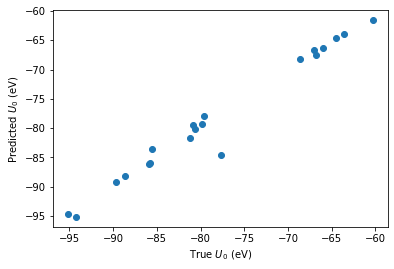

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(test_targets, predicted_tests, 'o')
plt.xlabel('True $U_0$ (eV)')
plt.ylabel('Predicted $U_0$ (eV)')

Results seem to be good considering that we are using 80 data points to train the model!

### Save and load model

In [46]:
from megnet.data.crystal import CrystalGraph
from megnet.data.graph import GaussianDistance
from megnet.models import MEGNetModel

import numpy as np

model = MEGNetModel(10, 2, nblocks=1, lr=1e-2,
                    n1=4, n2=4, n3=4, npass=1, ntarget=1,
                    graph_converter=CrystalGraph(bond_converter=GaussianDistance(np.linspace(0, 5, 10), 0.5)))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


#### Save model

In [47]:
model.save_model('test.hdf5')
weights1 = model.get_weights()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


#### Load model from file

In [48]:
model2 = MEGNetModel.from_file('test.hdf5')
weights2 = model2.get_weights()

In [49]:
all([np.allclose(weights1[i], weights2[i]) for i in range(len(weights1))])

True

### Transfer learning

In [50]:
import warnings
warnings.filterwarnings('ignore')

from megnet.models import MEGNetModel

#### Load formation energy model

In [51]:
model_form = MEGNetModel.from_file('megnet/mvl_models/mp-2018.6.1/formation_energy.hdf5')

#### Get the embedding layer

In [52]:
embedding_layer = [i for i in model_form.layers if i.name.startswith('embedding')][0]
embedding = embedding_layer.get_weights()[0]
print('Embedding matrix dimension is ', embedding.shape)

Embedding matrix dimension is  (95, 16)


The embedding matrix size is 95 x 16, so that the maximum atomic number (94) in the MP database can find the corresponding row in the embedding matrix.

#### Construct a new model and set embeddings

In [53]:
model = MEGNetModel(100, 2, nvocal=95, embedding_dim=16)

In [54]:
# find the embedding layer  index in all the model layers
embedding_layer_index = [i for i, j in enumerate(model.layers) if j.name.startswith('atom_embedding')][0]

# Set the weights to our previous embedding
model.layers[embedding_layer_index].set_weights([embedding])

# Freeze the weights
model.layers[embedding_layer_index].trainable = False

Now that <code>model</code> should have the same embeddings as the pre-trained model, and the weights won't change during training.